# 0. Definición del problema

Como parte de su estrategia de transformación digital, el Banco Digital de Chile (BDC) ha formado un selecto grupo de profesionales, del cual usted es parte, para implementar una serie de proyectos de inteligencia artificial y analítica. 

Su rol, dentro de la organización, es apoyar a los científicos de datos ya que ellos no tienen desarrolladas sus habilidades de Data Wrangling y necesitan un estrecho apoyo de los ingenieros de datos para llevar a cabo sus modelos de inteligencia artificial.

El proyecto actual en el que se encuentra participando, requiere que se construya una base de datos de información de la competencia en cuanto a las captaciones, colocaciones e inversiones a lo largo del tiempo. Esta tarea era desarrollada de forma manual por los analistas, quienes se conectaban a la página del Banco Central y descargaban las planillas Excel para alimentar los datos, pero se cometían muchos errores de transcripción, razón por la cual le han encomendado a usted que automatice un proceso de obtención y preparación de datos.

In [1]:
import pandas as pd
import re

# 1. Funciones sobre strings

En los diccionarios se usa el supuesto de que estas palabras siempre aparecen
escritas así en el archivo excel

In [2]:
monedas = {'pesos': 'CLP', 'dólares': 'USD'}
tipos = {'Colocaciones': 'Colocación', 'Depósitos': 'Depósito', 'Inversiones': 'Inversión'} 

def traducir_moneda(string):
    """Función auxiliar usada por get_moneda para transformar el string
    usando el diccionario monedas"""
    string = string.split(" ")[-1]
    moneda = monedas[string]
    return moneda

def traducir_tipo(string):
    """Función auxiliar usada por get_tipo para transformar el string
    usando el diccionario tipos"""
    string = string.split(" ")[0]
    tipo = tipos[string]
    return tipo

def traducir_subtipo(string):
    """Por ahora no hace nada
    """
    subtipo = string
    return subtipo

# 2. Funciones sobre dataframes

Se usa el supuesto de que el formato de los archivos no cambia

In [3]:
def get_moneda(dataframe):
    """Obtiene la moneda usada en el dataframe,
    bajo la suposición que siempre se encuentra en la
    misma posición.
    """
    moneda = dataframe.iat[(2,1)]
    moneda = traducir_moneda(moneda)
    return moneda

def get_subtipo(dataframe):
    """Obtiene el subtipo al que se refiere el dataframe,
    bajo la suposición que siempre se encuentra en la
    misma posición.
    """
    subtipo = dataframe.iat[(1,1)]
    subtipo = traducir_subtipo(subtipo)
    return subtipo

In [4]:
def renombrar_columnas(dataframe):
    """Función que renombra las columnas (excepto la primera) con el 
    contenido de la fila 4, bajo la suposición que esta fila siempre 
    contiene las fechas.
    """
    nuevas_columnas = list(dataframe.columns)
    nuevas_columnas[1] = 'Institución Financiera'
    nuevas_columnas[2:] = dataframe.iloc[4][2:]
    dataframe.columns = nuevas_columnas
    return dataframe

def limpiar(dataframe):
    """Elimina varias filas y columnas del dataframe, bajo
    el supuesto que el formato del archivo no cambia.
    Vease el ejemplo.
    """
    dataframe.drop(columns = 'Unnamed: 0', inplace = True) #Elimina la primera columna, que contiene principalmente metadatos.
    dataframe.dropna(subset = 'Institución Financiera', inplace = True) #Elimina las filas donde institución financiera es nula.
    dataframe.dropna(thresh = 2, inplace = True) #Elimina las filas de instituciones financieras que no tienen datos.
    fila_total = dataframe['Institución Financiera'] == 'Total' #Elimina la fila de totales.
    dataframe.drop(dataframe[fila_total].index, inplace = True)
    dataframe['Institución Financiera'] = dataframe['Institución Financiera'].apply(lambda banco: re.sub('\(\d.+','',banco)) #Eliminar notas
    dataframe['Institución Financiera'] = dataframe['Institución Financiera'].apply(lambda banco: banco.strip()) #Eliminar espacios en blanco  
    return dataframe

def cambiar_dtypes(dataframe):
    """Cambia el datatype de la columna de fechas y de valores.
    """
    dataframe['Fecha'] = pd.to_datetime(dataframe['Fecha'])
    dataframe['Valor'] = dataframe['Valor'].astype('float64')
    return dataframe

def agregar_columna(dataframe,nombre_columna,valor):
    """Agrega una columna con el dataframe cuyo único valor es el argumento valor"""
    dataframe[nombre_columna] = valor
    return dataframe

In [5]:
def dataframe_pipeline(dataframe,tipo):
    """Aplica todas las transformaciones a un dataframe.
    Vease el ejemplo
    """
    moneda = get_moneda(dataframe)
    subtipo = get_subtipo(dataframe)  
    dataframe = (
        dataframe.pipe(renombrar_columnas)
        .pipe(limpiar)
        .melt(id_vars = 'Institución Financiera', var_name = 'Fecha', value_name = 'Valor')
        .dropna()
        .pipe(cambiar_dtypes)
        .pipe(agregar_columna, 'Tipo', tipo)
        .pipe(agregar_columna, 'Subtipo', subtipo)
        .pipe(agregar_columna, 'Tipo de moneda', moneda)
    )
    return dataframe

# 3. Funciones sobre archivos excel
Entiendase por archivo excel, lo obtenido al aplicar pd.ExcelFile

Se usa el supuesto de que el formato de los archivos no cambia

In [6]:
def get_tipo(excel):
    """Obtiene el tipo de datos que contiene el archivo.
    Luego aplica la función traducir_tipo.
    """
    string = excel.sheet_names[0]
    tipo = string.split('_')[1]
    tipo = traducir_tipo(tipo)
    return tipo

def construir_dataframes(excel, *args, **kwargs):
    """Parsea las hojas del excel que contienen la informacion
    y construye una lista.
    Toma como argumento un archivo excel, los argumentos adicionales
    son pasados al método parse (que tiene los mismos argumentos que 
    read_excel).
    """
    nombres = excel.sheet_names[4:] #Obtiene los nombres de las hojas con la informacion
    dataframes = [excel.parse(sheet_name = hoja, *args, **kwargs) for hoja in nombres]
    return dataframes

def excel_pipeline(excel):
    """Aplica todas las transformaciones al archivo excel
    y devuelve un solo dataframe con toda la información
    """
    tipo = get_tipo(excel)
    data = construir_dataframes(excel, na_values = 'ND') #Crea la lista con todos los dataframes
    data = [dataframe_pipeline(dataframe,tipo) for dataframe in data] #Aplica el pipeline de dataframes a todos los dataframes
    data = pd.concat(data, ignore_index = True) #Concatena los archivos y resetea el index
    return data

Ejemplos detallados de lo que hacen las funciones se encuentran más abajo

# 4. Obtener archivo csv

El dataframe con toda la información se obtiene aplicando las funciones

In [7]:
excel = pd.ExcelFile('sdbcol_092021.xlsx')
datos = excel_pipeline(excel)
datos

,Institución Financiera,Fecha,Valor,Tipo,Subtipo,Tipo de moneda
0,Banco Bice,2008-01-31,1.763607e+06,Colocación,Colocaciones totales por tipo de crédito,CLP
1,Banco Consorcio,2008-01-31,3.392970e+04,Colocación,Colocaciones totales por tipo de crédito,CLP
2,Banco de Chile,2008-01-31,1.287716e+07,Colocación,Colocaciones totales por tipo de crédito,CLP
3,Banco de Crédito e Inversiones,2008-01-31,7.808180e+06,Colocación,Colocaciones totales por tipo de crédito,CLP
4,Banco de la Nación Argentina,2008-01-31,7.512129e+03,Colocación,Colocaciones totales por tipo de crédito,CLP
...,...,...,...,...,...,...
34481,"China Construction Bank, Agencia en Chile",2021-09-30,3.950805e+01,Colocación,Colocaciones contingentes en moneda extranjera,USD
34482,HSBC Bank (Chile),2021-09-30,6.804495e+00,Colocación,Colocaciones contingentes en moneda extranjera,USD
34483,"JP Morgan Chase Bank, N.A.",2021-09-30,0.000000e+00,Colocación,Colocaciones contingentes en moneda extranjera,USD
34484,Scotiabank Chile,2021-09-30,7.462811e+02,Colocación,Colocaciones contingentes en moneda extranjera,USD


Revisamos que no haya nada raro

In [8]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34486 entries, 0 to 34485
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Institución Financiera  34486 non-null  object        
 1   Fecha                   34486 non-null  datetime64[ns]
 2   Valor                   34486 non-null  float64       
 3   Tipo                    34486 non-null  object        
 4   Subtipo                 34486 non-null  object        
 5   Tipo de moneda          34486 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 1.6+ MB


In [9]:
datos.isnull().sum()

Institución Financiera    0
Fecha                     0
Valor                     0
Tipo                      0
Subtipo                   0
Tipo de moneda            0
dtype: int64

In [10]:
datos.duplicated().sum()

np.int64(3)

In [11]:
duplicados = datos.duplicated(subset = ['Institución Financiera', 'Fecha', 'Subtipo'], keep = False)
datos[duplicados].sort_values(by = 'Institución Financiera').head(6)

,Institución Financiera,Fecha,Valor,Tipo,Subtipo,Tipo de moneda
30425,Banco BTG Pactual Chile,2019-12-31,86.627926,Colocación,Colocaciones efectivas en moneda extranjera,USD
30643,Banco BTG Pactual Chile,2019-12-31,257.726126,Colocación,Colocaciones efectivas en moneda extranjera,USD
30424,Banco Bice,2019-12-31,1184.049061,Colocación,Colocaciones efectivas en moneda extranjera,USD
30642,Banco Bice,2019-12-31,1239.643223,Colocación,Colocaciones efectivas en moneda extranjera,USD
30426,Banco Consorcio,2019-12-31,601.031233,Colocación,Colocaciones efectivas en moneda extranjera,USD
30644,Banco Consorcio,2019-12-31,789.924192,Colocación,Colocaciones efectivas en moneda extranjera,USD


Revisando el excel se puede ver que en efecto esta fecha se encuentra repetida, parece ser que la primera entrada debería ser
'2018-12-31', por lo que se hace un arreglo manual

In [12]:
fecha_erronea = datos.duplicated(subset = ['Institución Financiera', 'Fecha', 'Subtipo'], keep = 'last')
datos.loc[fecha_erronea, 'Fecha'] = pd.to_datetime('2018-12-31')
datos[duplicados].sort_values(by = 'Institución Financiera').head(6)

,Institución Financiera,Fecha,Valor,Tipo,Subtipo,Tipo de moneda
30425,Banco BTG Pactual Chile,2018-12-31,86.627926,Colocación,Colocaciones efectivas en moneda extranjera,USD
30643,Banco BTG Pactual Chile,2019-12-31,257.726126,Colocación,Colocaciones efectivas en moneda extranjera,USD
30424,Banco Bice,2018-12-31,1184.049061,Colocación,Colocaciones efectivas en moneda extranjera,USD
30642,Banco Bice,2019-12-31,1239.643223,Colocación,Colocaciones efectivas en moneda extranjera,USD
30426,Banco Consorcio,2018-12-31,601.031233,Colocación,Colocaciones efectivas en moneda extranjera,USD
30644,Banco Consorcio,2019-12-31,789.924192,Colocación,Colocaciones efectivas en moneda extranjera,USD


In [13]:
[datos[columna].unique() for columna in datos]

[array(['Banco Bice', 'Banco Consorcio', 'Banco de Chile',
        'Banco de Crédito e Inversiones', 'Banco de la Nación Argentina',
        'Banco del Estado de Chile', 'Banco do Brasil S.A.',
        'Banco Falabella', 'Banco Internacional', 'Banco Itaú Corpbanca',
        'Banco Paris', 'Banco Penta', 'Banco Ripley',
        'Banco Santander - Chile', 'Banco Security', 'Banco Sudamericano',
        'Deutsche Bank (Chile)', 'HSBC Bank (Chile)',
        'JP Morgan Chase Bank, N.A.', 'Rabobank Chile', 'Scotiabank Chile',
        'The Bank of Tokyo - Mitsubishi Ufj. Ltd.', 'DnB NOR Bank ASA',
        'Banco BTG Pactual Chile',
        'China Construction Bank, Agencia en Chile', 'Bank of China'],
       dtype=object),
 <DatetimeArray>
 ['2008-01-31 00:00:00', '2008-02-29 00:00:00', '2008-03-31 00:00:00',
  '2008-04-30 00:00:00', '2008-05-31 00:00:00', '2008-06-30 00:00:00',
  '2008-07-31 00:00:00', '2008-08-31 00:00:00', '2008-09-30 00:00:00',
  '2008-10-31 00:00:00',
  ...
  '2021-04-3

In [14]:
datos['Fecha'].value_counts()

Fecha
2009-10-31    230
2009-06-30    230
2009-07-31    230
2009-08-31    230
2009-05-31    230
             ... 
2018-03-31    152
2018-03-29     38
2017-12-29     19
2018-06-29     19
2019-03-29     18
Name: count, Length: 169, dtype: int64

Las fechas parecen tener distinta frecuencia, pero coincide con lo observado en el excel

<Axes: >

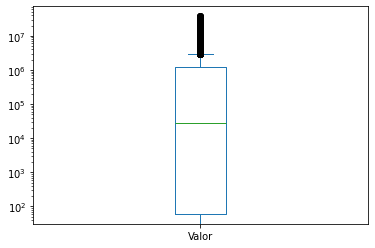

In [47]:
datos['Valor'].plot(kind = 'box', logy = True)

Se ven muchos valores marcados como outliers, pero no parece haber nada raro

In [16]:
datos['Valor'].describe()

count    3.448600e+04
mean     2.093504e+06
std      4.911500e+06
min     -3.265893e-04
25%      6.029675e+01
50%      2.728235e+04
75%      1.199643e+06
max      3.752273e+07
Name: Valor, dtype: float64

In [17]:
datos[datos['Valor'] < 0]

,Institución Financiera,Fecha,Valor,Tipo,Subtipo,Tipo de moneda
33591,Banco Falabella,2017-09-30,-0.000327,Colocación,Colocaciones contingentes en moneda extranjera,USD


Este valor negativo se ve raro, pero no conozco suficiente sobre bancos para saber como tratarlo, asi que se quedará así.

In [18]:
datos.to_csv('sdbcol_092021.csv', index = False)

# 5. Ejemplos de funciones y pipelines

## Ejemplo de aplicación del pipeline de excel

In [19]:
#Leer archivo, obtener tipo y parsear hojas
archivo = pd.ExcelFile('sdbcol_092021.xlsx')
tipo = get_tipo(archivo) #Extracción de metadatos
dfs = construir_dataframes(archivo, na_values = 'ND') #dfs es una lista de dataframes
print (f"""La variable dfs es de tipo {(type(dfs))}, contiene {len(dfs)} elementos de tipo {type(dfs[0])}, y 
contiene la información financiera '{tipo}'""")

La variable dfs es de tipo <class 'list'>, contiene 10 elementos de tipo <class 'pandas.core.frame.DataFrame'>, y 
contiene la información financiera 'Colocación'


Luego se aplica la función que llama el pipeline del dataframe, por lo que sigue un ejemplo de esto 
antes de continuar con el pipeline del excel:

## Ejemplo de aplicación del pipeline de dataframe

In [20]:
df = dfs[0].copy() #Usar primer dataframe como ejemplo
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166
0,Índice general,Cuadro 1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Notas generales,Colocaciones totales por tipo de crédito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Conceptualización,Saldos en millones de pesos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,...,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00


### Primero se aplican las funciones para extraer el subtipo y el tipo de moneda

In [21]:
#Extracción de metadatos
subtipo = get_subtipo(df)
moneda = get_moneda(df)
print(f"Subtipo: {subtipo}, moneda: {moneda}")

Subtipo: Colocaciones totales por tipo de crédito, moneda: CLP


### Se aplica la funcion renombrar columnas

In [22]:
df = df.pipe(renombrar_columnas)
df.head(2)

,Unnamed: 0,Institución Financiera,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,...,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00
0,Índice general,Cuadro 1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Notas generales,Colocaciones totales por tipo de crédito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### La función limpiar realiza 5 operaciones distintas, por lo que se realizarán de forma manual:

##### 1: Eliminar la primera columna, que contiene principalmente metadatos.

In [23]:
df.drop(columns = 'Unnamed: 0', inplace = True)
df.head(5)

,Institución Financiera,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,...,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00
0,Cuadro 1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Colocaciones totales por tipo de crédito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Saldos en millones de pesos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,...,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00


##### 2: Eliminar las filas donde institución financiera es nula

In [24]:
bancos_nulos = df['Institución Financiera'].isnull().sum()
print(f"Existen {bancos_nulos} filas con institución financiera nula")

Existen 5 filas con institución financiera nula


In [25]:
df.dropna(subset = 'Institución Financiera', inplace = True)
df.head(5)

,Institución Financiera,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,...,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00
0,Cuadro 1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Colocaciones totales por tipo de crédito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Saldos en millones de pesos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Banco Bice,1763607.105975,1808429.613026,1842186.397327,1881593.219611,1941444.983769,2019770.333121,1994761.128546,2041350.403024,2097468.789285,...,6660939.273511,6743346.724603,6778835.359596,6855606.729749,6914693.776389,6943833.340858,6963353.113535,7142790.483542,7209759.998717,7336544.759679
6,Banco BTG Pactual Chile (9),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1207031.841972,1219968.641785,1236017.530255,1284157.56313,1347129.374373,1379468.722384,1371803.875966,1366410.319041,1340045.201823,1427693.447579


##### 3: Eliminar instituciones financieras sin información

Hay varias filas que no corresponden a instituciones financieras
las cuales afortunadamente solo contienen entradas nulas en las otras columnas

In [26]:
df['Institución Financiera'].unique()

array(['Cuadro 1.01', 'Colocaciones totales por tipo de crédito',
       'Saldos en millones de pesos', 'Banco Bice',
       'Banco BTG Pactual Chile (9)', 'Banco Consorcio (1)',
       'Banco de Chile (2)', 'Banco de Crédito e Inversiones',
       'Banco de la Nación Argentina (18)', 'Banco del Estado de Chile',
       'Banco do Brasil S.A.', 'Banco Falabella', 'Banco Internacional',
       'Banco Itaú Corpbanca (10)', 'Banco Paris (13)',
       'Banco Penta (14)', 'Banco Ripley', 'Banco Santander - Chile',
       'Banco Security', 'Banco Sudamericano (4) (5) (6)',
       'China Construction Bank, Agencia en Chile (11)',
       'Deutsche Bank (Chile) (12)', 'DnB NOR Bank ASA (7) (8)',
       'HSBC Bank (Chile)', 'JP Morgan Chase Bank, N.A.',
       'Rabobank Chile (15)', 'Scotiabank Chile (3) (17)',
       'The Bank of Tokyo - Mitsubishi Ufj. Ltd. (19)',
       'Bank of China (16)', 'Total', 'ND : No existe dato',
       'Conceptualización: Vínculo que remite al documento conceptual d

In [27]:
df.dropna(thresh = 2, inplace = True)
df.head()

,Institución Financiera,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,...,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00
5,Banco Bice,1763607.105975,1808429.613026,1842186.397327,1881593.219611,1941444.983769,2019770.333121,1994761.128546,2041350.403024,2097468.789285,...,6660939.273511,6743346.724603,6778835.359596,6855606.729749,6914693.776389,6943833.340858,6963353.113535,7142790.483542,7209759.998717,7336544.759679
6,Banco BTG Pactual Chile (9),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1207031.841972,1219968.641785,1236017.530255,1284157.56313,1347129.374373,1379468.722384,1371803.875966,1366410.319041,1340045.201823,1427693.447579
7,Banco Consorcio (1),33929.700249,32239.758181,29778.804888,30171.072657,30523.044437,29617.013329,28433.274784,28789.410595,27307.815688,...,3853309.703266,3916265.732864,3953007.770653,4032344.163441,4085867.277682,4133305.337242,4213702.419961,4308445.136471,4376367.343655,4505780.371801
8,Banco de Chile (2),12877155.584751,12938268.35506,12917905.116482,13360065.085286,13569024.968038,13949444.90434,14109592.483322,14273878.18692,14612482.956035,...,33530872.414165,33834355.823993,34465235.240519,34596652.927615,34624500.131196,34869098.251843,35032258.93999,35391502.872062,35692339.930566,36178962.654881
9,Banco de Crédito e Inversiones,7808179.921376,8018036.14873,7963030.739069,8218231.96764,8371478.070525,8637648.684119,8709819.421841,8879434.238024,9140628.817782,...,26190639.963327,26535502.328814,26504578.630271,26431547.811907,26591194.825338,26757887.372684,26808512.575706,27477333.314595,27726659.150136,28180479.929407


In [28]:
df['Institución Financiera'].unique()

array(['Banco Bice', 'Banco BTG Pactual Chile (9)', 'Banco Consorcio (1)',
       'Banco de Chile (2)', 'Banco de Crédito e Inversiones',
       'Banco de la Nación Argentina (18)', 'Banco del Estado de Chile',
       'Banco do Brasil S.A.', 'Banco Falabella', 'Banco Internacional',
       'Banco Itaú Corpbanca (10)', 'Banco Paris (13)',
       'Banco Penta (14)', 'Banco Ripley', 'Banco Santander - Chile',
       'Banco Security', 'Banco Sudamericano (4) (5) (6)',
       'China Construction Bank, Agencia en Chile (11)',
       'Deutsche Bank (Chile) (12)', 'DnB NOR Bank ASA (7) (8)',
       'HSBC Bank (Chile)', 'JP Morgan Chase Bank, N.A.',
       'Rabobank Chile (15)', 'Scotiabank Chile (3) (17)',
       'The Bank of Tokyo - Mitsubishi Ufj. Ltd. (19)',
       'Bank of China (16)', 'Total'], dtype=object)

##### 4: Eliminar la fila de totales

In [29]:
df.tail(1)

,Institución Financiera,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,...,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00
31,Total,63289823.285317,63929598.124746,64331272.198998,66239592.233475,67501410.730421,69337022.107028,69845545.246008,70735554.989043,72284209.120933,...,188919524.712304,190314097.069002,191177693.341645,192185791.786168,192752520.181099,193600431.542033,194676324.255656,197863032.094719,199568992.825879,202337502.110627


In [30]:
fila_total = df['Institución Financiera'] == 'Total' #Elimina la fila de totales.
df.drop(df[fila_total].index, inplace = True)

In [31]:
df.tail(1)

,Institución Financiera,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,...,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00
30,Bank of China (16),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df['Institución Financiera'].unique()

array(['Banco Bice', 'Banco BTG Pactual Chile (9)', 'Banco Consorcio (1)',
       'Banco de Chile (2)', 'Banco de Crédito e Inversiones',
       'Banco de la Nación Argentina (18)', 'Banco del Estado de Chile',
       'Banco do Brasil S.A.', 'Banco Falabella', 'Banco Internacional',
       'Banco Itaú Corpbanca (10)', 'Banco Paris (13)',
       'Banco Penta (14)', 'Banco Ripley', 'Banco Santander - Chile',
       'Banco Security', 'Banco Sudamericano (4) (5) (6)',
       'China Construction Bank, Agencia en Chile (11)',
       'Deutsche Bank (Chile) (12)', 'DnB NOR Bank ASA (7) (8)',
       'HSBC Bank (Chile)', 'JP Morgan Chase Bank, N.A.',
       'Rabobank Chile (15)', 'Scotiabank Chile (3) (17)',
       'The Bank of Tokyo - Mitsubishi Ufj. Ltd. (19)',
       'Bank of China (16)'], dtype=object)

##### 5: Eliminar notas de las instituciones financieras

Los nombres de los bancos tienen numeros entre parentesis, que no son parte del nombre si no que son parte de
las notas generales.

In [33]:
#Eliminar todo despues de un parentesis con números
df['Institución Financiera'] = df['Institución Financiera'].apply(lambda banco: re.sub('\(\d.+','',banco))
#Eliminar espacios en blanco
df['Institución Financiera'] = df['Institución Financiera'].apply(lambda banco: banco.strip())
df['Institución Financiera'].unique()

array(['Banco Bice', 'Banco BTG Pactual Chile', 'Banco Consorcio',
       'Banco de Chile', 'Banco de Crédito e Inversiones',
       'Banco de la Nación Argentina', 'Banco del Estado de Chile',
       'Banco do Brasil S.A.', 'Banco Falabella', 'Banco Internacional',
       'Banco Itaú Corpbanca', 'Banco Paris', 'Banco Penta',
       'Banco Ripley', 'Banco Santander - Chile', 'Banco Security',
       'Banco Sudamericano', 'China Construction Bank, Agencia en Chile',
       'Deutsche Bank (Chile)', 'DnB NOR Bank ASA', 'HSBC Bank (Chile)',
       'JP Morgan Chase Bank, N.A.', 'Rabobank Chile', 'Scotiabank Chile',
       'The Bank of Tokyo - Mitsubishi Ufj. Ltd.', 'Bank of China'],
      dtype=object)

### Luego se despivotea la tabla

In [34]:
df = df.melt(id_vars = 'Institución Financiera', var_name = 'Fecha', value_name = 'Valor')
df.head()

,Institución Financiera,Fecha,Valor
0,Banco Bice,2008-01-31 00:00:00,1763607.105975
1,Banco BTG Pactual Chile,2008-01-31 00:00:00,NaN
2,Banco Consorcio,2008-01-31 00:00:00,33929.700249
3,Banco de Chile,2008-01-31 00:00:00,12877155.584751
4,Banco de Crédito e Inversiones,2008-01-31 00:00:00,7808179.921376


### Se eliminan los valores nulos, que se encuentran todos ahora en la columna Valor

In [35]:
df.isnull().sum()

Institución Financiera      0
Fecha                       0
Valor                     842
dtype: int64

In [36]:
df.dropna(inplace = True)

### Se aplica la funcion cambiar_dtypes que cambia los tipos de la columna Fecha y Valor

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3448 entries, 0 to 4289
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Institución Financiera  3448 non-null   object
 1   Fecha                   3448 non-null   object
 2   Valor                   3448 non-null   object
dtypes: object(3)
memory usage: 107.8+ KB


In [38]:
df = df.pipe(cambiar_dtypes)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3448 entries, 0 to 4289
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Institución Financiera  3448 non-null   object        
 1   Fecha                   3448 non-null   datetime64[ns]
 2   Valor                   3448 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 107.8+ KB


### Se aplica la función agregar_columna 3 veces para agregar las columnas 'Tipo', 'Subtipo' y 'Tipo de moneda'

In [39]:
df.head()

,Institución Financiera,Fecha,Valor
0,Banco Bice,2008-01-31,1.763607e+06
2,Banco Consorcio,2008-01-31,3.392970e+04
3,Banco de Chile,2008-01-31,1.287716e+07
4,Banco de Crédito e Inversiones,2008-01-31,7.808180e+06
5,Banco de la Nación Argentina,2008-01-31,7.512129e+03


In [40]:
df = (
     df.pipe(agregar_columna, 'Tipo', tipo)
       .pipe(agregar_columna, 'Subtipo', subtipo)
       .pipe(agregar_columna, 'Tipo de moneda', moneda)
)
df.head()

,Institución Financiera,Fecha,Valor,Tipo,Subtipo,Tipo de moneda
0,Banco Bice,2008-01-31,1.763607e+06,Colocación,Colocaciones totales por tipo de crédito,CLP
2,Banco Consorcio,2008-01-31,3.392970e+04,Colocación,Colocaciones totales por tipo de crédito,CLP
3,Banco de Chile,2008-01-31,1.287716e+07,Colocación,Colocaciones totales por tipo de crédito,CLP
4,Banco de Crédito e Inversiones,2008-01-31,7.808180e+06,Colocación,Colocaciones totales por tipo de crédito,CLP
5,Banco de la Nación Argentina,2008-01-31,7.512129e+03,Colocación,Colocaciones totales por tipo de crédito,CLP


Esa fue la última operación realizada por la función dataframe_pipeline, que es aplicada por la función excel_pipeline sobre todos los dataframes de la lista 'dfs'.

Ahora se continúa con el ejemplo del pipeline de excel

## Se aplica la función dataframe_pipeline sobre la lista 'dfs'

##### Comprobamos que la función dataframe_pipeline hace lo que se expuso recién en el ejemplo

In [41]:
pd.DataFrame.equals(df,dfs[0])

False

In [42]:
dfs = [dataframe_pipeline(dataframe,tipo) for dataframe in dfs]
pd.DataFrame.equals(df,dfs[0])

True

In [43]:
dfs[1].head()

,Institución Financiera,Fecha,Valor,Tipo,Subtipo,Tipo de moneda
0,Banco Bice,2008-01-31,1.349841e+06,Colocación,Colocaciones comerciales,CLP
2,Banco Consorcio,2008-01-31,3.284005e+04,Colocación,Colocaciones comerciales,CLP
3,Banco de Chile,2008-01-31,8.012788e+06,Colocación,Colocaciones comerciales,CLP
4,Banco de Crédito e Inversiones,2008-01-31,4.855261e+06,Colocación,Colocaciones comerciales,CLP
5,Banco de la Nación Argentina,2008-01-31,4.001099e+03,Colocación,Colocaciones comerciales,CLP


In [44]:
dfs[1].shape

(3448, 6)

## Se concatenan todos los dataframes de la lista y se resetea el index

In [45]:
df_final = pd.concat(dfs, ignore_index = True)

In [46]:
df_final

,Institución Financiera,Fecha,Valor,Tipo,Subtipo,Tipo de moneda
0,Banco Bice,2008-01-31,1.763607e+06,Colocación,Colocaciones totales por tipo de crédito,CLP
1,Banco Consorcio,2008-01-31,3.392970e+04,Colocación,Colocaciones totales por tipo de crédito,CLP
2,Banco de Chile,2008-01-31,1.287716e+07,Colocación,Colocaciones totales por tipo de crédito,CLP
3,Banco de Crédito e Inversiones,2008-01-31,7.808180e+06,Colocación,Colocaciones totales por tipo de crédito,CLP
4,Banco de la Nación Argentina,2008-01-31,7.512129e+03,Colocación,Colocaciones totales por tipo de crédito,CLP
...,...,...,...,...,...,...
34481,"China Construction Bank, Agencia en Chile",2021-09-30,3.950805e+01,Colocación,Colocaciones contingentes en moneda extranjera,USD
34482,HSBC Bank (Chile),2021-09-30,6.804495e+00,Colocación,Colocaciones contingentes en moneda extranjera,USD
34483,"JP Morgan Chase Bank, N.A.",2021-09-30,0.000000e+00,Colocación,Colocaciones contingentes en moneda extranjera,USD
34484,Scotiabank Chile,2021-09-30,7.462811e+02,Colocación,Colocaciones contingentes en moneda extranjera,USD


# Fin